# Julia Differentiation

Analyzing different types of differentiation between analytic, numerical, and automatic differentiation

### Utility Functions

We'll use the Plots package from julia to visualize the results as shown in ```plot_f```.

In [1]:
using Plots

function plot_f(f, a, b, n)
    x = range(a, b, length=n)
    y = f.(x)
    plot(x, y, label="f(x)")
end

function plot_f(f, df, a, b, n)
    x = range(a, b, length=n)
    y = f.(x)
    plot(x, y, label="f(x)")
    y = df.(x)
    plot!(x, y, label="f'(x)")
end

function plot_f(f, df, ddf, a, b, n)
    x = range(a, b, length=n)
    y = f.(x)
    plot(x, y, label="f(x)")
    y = df.(x)
    plot!(x, y, label="f'(x)")
    y = ddf.(x)
    plot!(x, y, label="f''(x)")
end

plot_f (generic function with 3 methods)


### Analytic Differentiation

We'll use SymEngine to do the differentiation symbolically. This package provides a simple function call ```diff``` to perform the differentiation of a function with respect to a variable.

In the function below ```analytic_diff``` will take care of this for us.

In [2]:
using SymEngine

@vars x; # define x as a symbolic variable

function analytic_diff(f, x)
    df_dx = diff(f, x)
    return df_dx
end

analytic_diff (generic function with 1 method)

### Example

Let's start with a example: $f(x) = x^2 + x/2 - sin(x) / x$

We'll first plot it to see what it looks like.

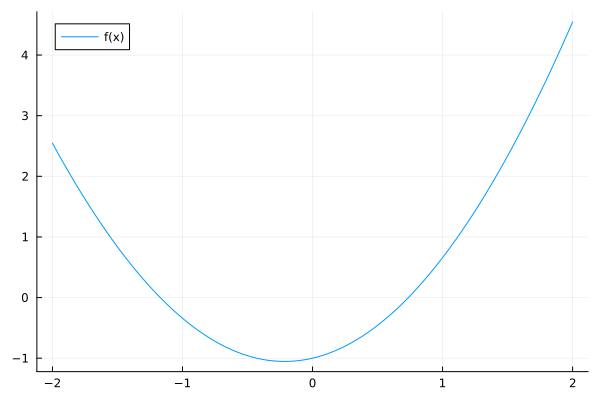

In [3]:
using Plots 

f = (z) -> z^2 + z/2 - sin(z) / z
plot_f(f, -2, 2, 100)

As we can see the dominant term $x^2$ is quadratic and the other terms are small perturbations.

Now lets evaluate the function and its derivatives using Analytical Differentiation.

In [4]:
f1 = x^2 + x/2 - sin(x) / x
println("f   = ", f1)

df_dx = analytic_diff(f1, x)
println("df/dx = ", df_dx)

ddf_dxx = analytic_diff(df_dx, x)
println("d^2f/dx^2 = ", ddf_dxx)

f   = (1/2)*x - sin(x)/x + x^2
df/dx = 1/2 + 2*x + sin(x)/x^2 - cos(x)/x
d^2f/dx^2 = 2 - 2*sin(x)/x^3 + 2*cos(x)/x^2 + sin(x)/x


As we can see analytic differentiation is able to capture the exact derivative of the function using algebra and calculus.

Let's evaluate the first order derivative over the same interval.

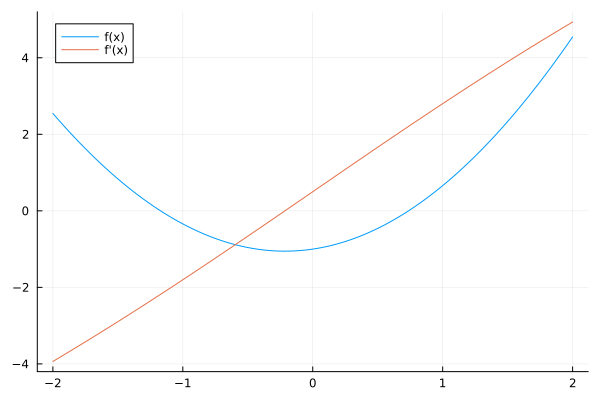

In [5]:
df = (z) -> 1/2 + 2 * z + sin(z) / z^2 - cos(z) / z

plot_f(f, df, -2, 2, 100)

Now let's evaluate the second order derivative over the same interval.

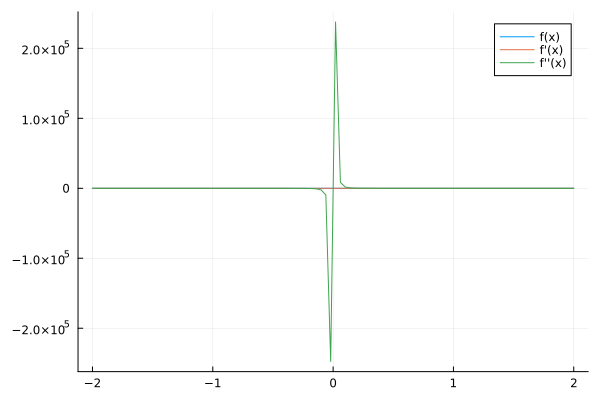

In [6]:
ddf = (z) -> 2 - 2 * sin(z) / z^3 + 2 * cos(z) / z^3 + sin(z) / z

plot_f(f, df, ddf, -2, 2, 100)

Wow! As we can see there are large discontinuities around zero.. this makes sense because the function is not differentiable at zero due to the poles in the function. But why is the first derivative so smooth?

Lets evaluate both at zero (we should expect nan)

In [7]:
println(df(0))
println(ddf(0))

NaN
NaN


Alright, this is what we expected. So let's zoom into our x range we're evaluating over.

In [8]:
z = range(-2, 2, 100)
println(z)

z = abs.(z)
println(minimum(z))

-2.0:0.04040404040404041:2.0
0.020202020202020204


It appears over a range from [-2, 2] with 100 numbers we have a step size of 0.0404 repeating. Furthermore, looking into our discretization the minimum value is 0.02! This is why we're not seeing the discontinuities in the first derivative, however we see the large discontinuities in the second derivative due to the larger trigonometric terms. Additionally the second derivative reflects changes in the curvature of the function which is why we see the large changes in those particular regions of x.

This should be a good example of why we need to be careful when using numerical differentiation.

### Numerical Differentiation

#### Finite Difference Methods

There's essentially three different types of finite difference methods where h represents the step size

- Forward Difference: $f'(x) = (f(x + h) - f(x)) / h$

The error in this approximation is $h$

- Central Difference: $f'(x) = (f(x + h/2) - f(x - h/2)) / h$

The error in this approximation is $h^2$

- Backward Difference: $f'(x) = (f(x) - f(x - h)) / h$

This has a similar error as forward difference.

In [9]:
diff_forward(f, z; h=sqrt(eps(Float64))) = (f(z + h) - f(z)) / h
diff_central(f, z; h=cbrt(eps(Float64))) = (f(z + h/2) - f(z - h/2)) / h
diff_backward(f, z; h=sqrt(eps(Float64))) = (f(z) - f(z - h)) / h

diff_backward (generic function with 1 method)

We'll first define the same function as before and compute the first and second order derivatives 

In [10]:
f = (z) -> z^2 + z/2 - sin(z) / z

df_dx = diff_forward(f, 1)
println("df/dx = ", df_dx)

df_dz = diff_central(f, 1)
println("df/dx = ", df_dx)

df_dz = diff_backward(f, 1)
println("df/dx = ", df_dx)

df/dx = 2.8011686950922012
df/dx = 2.8011686950922012
df/dx = 2.8011686950922012


The other method that can be used is called the complex step method which can alleviate numerical step issues.

Complex Step: $Im(f(x + ih) / h$

In [11]:
complex_step(f, z; h=sqrt(eps(Float64))) = imag(f(z + im*h)) / h

complex_step (generic function with 1 method)

In [12]:
df_dx = complex_step(f, 1)
println("df/dx = ", df_dx)

df/dx = 2.801168678939757


### Auto Differentiation 

There's essentially two types of this kind of differentiation:

#### Forward Accumulation
In this type of accumulation we evaluate the function in a forward pass manner returning the result as a dual variable (e.g., val, df).

For example: $f = y * (x^2 + x)$ and $df/dx$ evaluated at x = 1, y = 2

1. Evaluate $x * x$ & evaluate $df/dx = 2x$ 
3. Add the result from (1) with x & evaluate $df/dx = 1$ 
4. Multiple the result from (2) with y & evaluate $df/dx = 2xy + y$
5. Return $(4, 6)$

In [13]:
using ForwardDiff # using this to evaluate df/dx on univariate function

func(z) = sin(z)

z = pi/4

ForwardDiff.derivative(func, z) # you can also do gradient and hessian with a vector

0.7071067811865476

#### Reverse Accumulation
This is how backward propagation is formed in neural networks when performing stochastic gradient descent or something similar. In this algorithm we perform a forward pass evaluating the original function and calculating the gradient at each step in the computational graph. We then move backwards in the computational graph starting at the output and perform partial derivatives (i.e., evaluating the gradients) moving backwards in the graph towards the inputs. In essence we take the intermediate values computed in each step of the forward pass to evaluate the gradients in the backward pass-- this is more memory efficent than forward accumulation.

Same example continued with $df_dy$
1. $df/dy = x^2 + x$ or $x(x + 1)$
2. return (df/dx, df/dy) would be (6, 2)

In [14]:
using Zygote: gradient

func_z(a, b) = b * (a^2 + a)

gradient(func_z, 1., 2.)

(6.0, 2.0)

### Crediting the following sources

- Algorithms for Optimization book
- https://juliadiff.org/